<a href="https://colab.research.google.com/github/jewbe22/eecs4415_Big_data/blob/main/project_2/Task_6_Exploring_Big_Data_with_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EECS 4415 - Part 6
## Exploring Big Data with Embedding Techniques

### Setup

First of all, we install the [graph2vec library](https://github.com/VHRanger/graph2vec) which offers a fast implementation of the node2vec method.

To learn how to implement fast random walks on graphs,  [read the blog post](https://www.singlelunch.com/2019/08/01/700x-faster-node2vec-models-fastest-random-walks-on-a-graph/) which explains some of the design choices behind this library.

In [1]:
!python -m pip install 'csrgraph @ git+https://github.com/VHRanger/CSRGraph@f052c1cf128ab21d21a4710337dc7c1cd5658df7'
!python -m pip install 'nodevectors @ git+https://github.com/aman0456/nodevectors@67e9af0506236be9aae6d460e96d4dec6329bcd2'

  Using cached csrgraph-0.1.29-py3-none-any.whl
  Using cached nodevectors-0.1.23-py3-none-any.whl


We now import the library, and create a small wrapper class which will expose only the few hyperparameters we will need to tune in this Colab

In [2]:
from nodevectors import Node2Vec
import networkx as nx

class Node2VecNew(Node2Vec):
  """
  Parameters
  ----------
  p : float
      p parameter of node2vec
  q : float
      q parameter of node2vec
  d : int
      dimensionality of the embedding vectors
  """
  def __init__(self, p=1, q=1, d=32):
    super().__init__(
                 n_components=d,
                     walklen=10,
                     epochs=50,
                     return_weight=1.0/p,
                     neighbor_weight=1.0/q,
                     threads=0,
                     w2vparams={'window': 4,
                                'negative': 5,
                                'iter': 10,
                                'ns_exponent': 0.5,
                                'batch_words': 128})

Lastly, let's import some of the common libraries needed for our task.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

Function to print graph information

In [4]:
def print_graph_info(G, directed=True):
  print("Number of nodes:", len(G.nodes))
  print("Number of edges:", len(G.edges))
  if directed:
    print("Average in-degree:", sum(dict(G.in_degree).values()) / len(G.nodes))
    print("Average out-degree:", sum(dict(G.out_degree).values()) / len(G.nodes))
  else:
    print("Average degree:", sum(dict(G.degree).values()) / len(G.nodes))

### Example

In the example below, we will try to reproduce the plot in the lecture notes.

In [5]:
# Load the Zachary's Karate Club as a NetworkX Graph object
KCG = nx.karate_club_graph()

# Fit embedding model to the Karate Club graph
n2v = Node2VecNew(1, 1, 2)
n2v.fit(KCG)

Making walks... Done, T=12.48
Mapping Walk Names... Done, T=0.04
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=0.37


In [6]:
embeddings = []
for node in KCG.nodes:
  embedding = list(n2v.predict(node))
  club = KCG.nodes[node]['club']
  embeddings.append(embedding + [club])

# Construct a pandas dataframe with the 2D embeddings from node2vec,
# plus the club name that each node belongs to after the split
df = pd.DataFrame(embeddings, columns=['x', 'y', 'club'])

<Axes: xlabel='x', ylabel='y'>

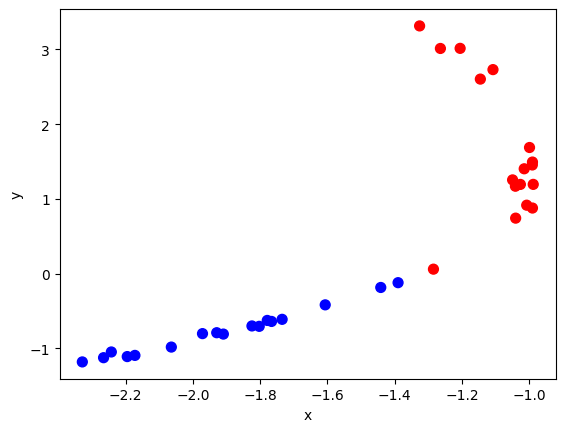

In [7]:
# Nodes who stayed with the Mr. Hi will be plotted in red, while nodes
# who moved with the Officer will be plotted in blue
colors = ['red' if x == 'Mr. Hi' else 'blue' for x in df.club]
df.plot.scatter(x='x', y='y', s=50, c=colors)

If our example trained correctly, you should notice a clear separation between the blue and red nodes.  Solely from the graph structure, node2vec could predict how the Zachary's Karate Club split!

Tune the hyperparameters ```p``` and ```q```, and notice how they affect the resulting embeddings.

1. p > 1: as p grows larger, embeddings show tendancy of clear separation in most of the time. However, repeated execution of fitting embedding model sometimes yields one or two embeddings of each color not so clearly separated.
2. q > 1: as q grows larger, seperation of blue and red nodes becomes severely compromised by around 50% chance. When this happens, the graph shows blue dots are enclosed by red ones as if we can have 3 seperation instead of 2.
3. p < 1: as p approaches to 0, blue and red nodes distributed almost randomly and become inseperable in some cases.
4. q < 1: repeated execution of fitting embedding mode shows all the patterns mentioned above sometimes.

### Your Task

Now we will study the behavior of node2vec on [barbell graphs](https://mathworld.wolfram.com/BarbellGraph.html).

Below you can see a toy example of a barbell graph generated with NetworkX.

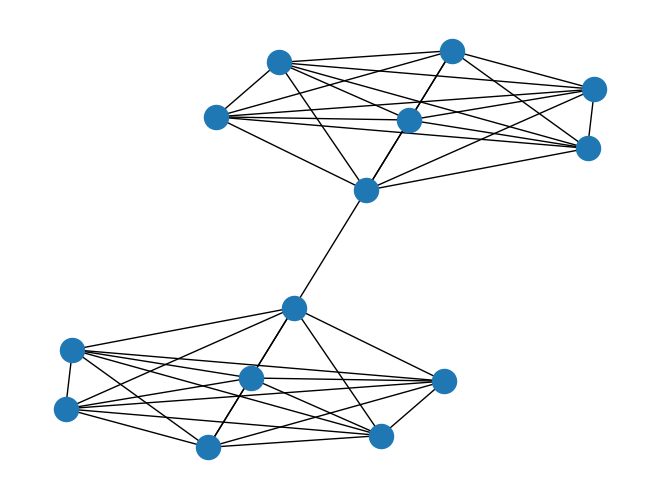

In [8]:
toy_barbell = nx.barbell_graph(7, 0)
nx.draw_kamada_kawai(toy_barbell)

Generate a larger barbell graph, where each complete graph has exactly 1000 nodes. Print graph information.

Then, learn node2vec embeddings on this graph, setting ```p = 1, q = 1``` and ```d = 10```.

In [9]:
''' 5-7 lines of code in total expected but can differ based on your style.'''

# YOUR CODE HERE
barbell = nx.barbell_graph(1000, 0)
print_graph_info(barbell, False)
barbell_n2v = Node2VecNew(1, 1, 10)
barbell_n2v.fit(barbell)
barbell_embeddings = []
for node in barbell.nodes:
  barbell_embeddings.append(list(barbell_n2v.predict(node)))


Number of nodes: 2000
Number of edges: 999001
Average degree: 999.001
Making walks... Done, T=1.62
Mapping Walk Names... Done, T=0.50
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=24.76


Write a function that takes as input a node id ```n``` in the graph and returns a list containining the cosine similarity between the node2vec vector of the input node ```n``` and all the nodes in the given barbell graph (including the similarity with ```n``` itself).

In [10]:
''' 12-20 lines of code in total expected but can differ based on your style.'''

# YOUR CODE HERE
from sklearn.metrics.pairwise import cosine_similarity

def cos_sim(n, v):
  df = pd.DataFrame(barbell_embeddings, columns=range(len(barbell_embeddings[0])), index=range(len(barbell_embeddings)))
  cosine = cosine_similarity(df.loc[n].values.reshape(1, -1), df.values)
  return pd.DataFrame(cosine, columns=df.index, index=[n])


Print the result of the function for n=5.

In [11]:
''' 1 line of code in total expected.'''

#YOUR CODE HERE
cos_sim(5, barbell_embeddings)


,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
5,0.922979,0.936762,0.955705,0.954775,0.939406,1.0,0.912121,0.938216,0.927516,0.976644,...,0.145497,0.102861,0.13255,0.150351,0.12564,0.125454,0.149907,0.140437,0.087966,0.112608


Write the function to compute the number of nodes in the graph whose embeddings have exactly 1000 neighbors with a cosine similarity greater than 0.8. Print the result.

In [12]:
''' 12-15 lines of code in total expected but can differ based on your style.'''

#YOUR CODE HERE
def node_filter(embeddings, neighbors, cos_threshold):
  df = pd.DataFrame(embeddings, columns=range(len(embeddings[0])), index=range(len(embeddings)))
  cosine = cosine_similarity(df, df)
  cosine_filtered = []
  for row in cosine:
    count = 0
    for value in row:
      if eval("%s%s" % (value, cos_threshold)):
        count += 1
    #excluding the similarity from one node to itself by adding 1 to count
    if eval("%s%s" % (count+1, neighbors)):
      cosine_filtered.append(row)
  return len(cosine_filtered)

print("Number of nodes in the graph satisfies the given condition: ",node_filter(barbell_embeddings, '==1000', '>0.8'))


Number of nodes in the graph satisfies the given condition:  246


Generate another barbell graph, this time adding a path of length 51 between

---

the two complete graphs and print graph information. To find out how, refer to the NetworkX documentation: [https://networkx.github.io/documentation/stable/reference/

---

generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph)

Learn the node2vec embeddings for the nodes of this new graph, using the same hyperparameters as before.

In [13]:
''' 4-6 lines of code in total expected but can differ based on your style.'''

# YOUR CODE HERE
another_barbell = nx.barbell_graph(1000, 51)
print_graph_info(another_barbell, False)
barbell_n2v = Node2VecNew(1, 1, 10)
barbell_n2v.fit(another_barbell)
another_embeddings = []
for node in another_barbell.nodes:
  another_embeddings.append(list(barbell_n2v.predict(node)))

Number of nodes: 2051
Number of edges: 999052
Average degree: 974.2096538274012
Making walks... Done, T=1.00
Mapping Walk Names... Done, T=0.51
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=24.67


Print the number of nodes in the graph whose embeddings have exactly 1000 neighbors with a cosine similarity greater than 0.8.

In [14]:
''' 1 line of code in total expected.'''

# YOUR CODE HERE
print("Number of nodes satisfies the given condition: " ,node_filter(another_embeddings, '==1000', '>0.8'))

Number of nodes satisfies the given condition:  1253


Write a function to compute the number of nodes in the graph whose embeddings have less than 100 neighbors with a cosine similarity greater than 0.8. Print the result.

In [15]:
''' 6-10 lines of code in total expected but can differ based on your style.'''

# YOUR CODE HERE
print("Number of nodes satisfies the given condition: ", node_filter(another_embeddings, '<100', '>0.8'))

Number of nodes satisfies the given condition:  53


Write a paragraph of conclusions below summarizing your insights.

Since the parameter p and q are set to one, node2vec follows complete random walk (neither BFS nor DFS like). In this situation, the cosine_similarity of embedding of two nodes implies the probability of both nodes appears in some random walk starting from one node to the other. In case of the barbell with 0 connecting length, a node in a complete graph is reachable to the other 999 node in the same complete graph with high chance. However, the chance of a node in one complete graph reaching to some node (except the connecting node) in the other complete graph is quite low since the path must consist of the node that connects the two complete graphs, and pick the right path from the other complete graph. On the other hand, the barbell graph with connecting length of 51, the chance of the walk consisting the connecting node is still small, but if it is the case, the walk can reach the neighbor (which is the other node of connecting path) with 50% chance, either go forward or back. This leads a node in a complete graph has 1000 nodes of cosine similarity >0.8. Therefore, more nodes that satisfy the condition appears as a result compared to the previous example. Meanwhile, the number of nodes that have less than 100 neighbors with cosine similarity >0.8 shows the result around 52 because the nodes that are reachable to less than 100 nodes must be the nodes in the connecting path.  

Once you have working code for each cell above, **head over to eClass and submit your solution for this Colab**!
